In [1]:
from matplotlib import pyplot as plt
import scipy.io as sio
import numpy as np

In [2]:
SMALL_SIZE = 13
MEDIUM_SIZE = 25
BIGGER_SIZE = 25

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [3]:
num_seed = 1
num_tasks = 10

date = '211012'
dataset = 'split_cifar100'

method = 'rwalk_cpr'
lamb = 8.0
cpr_beta = [0.0, 0.9]

#  211012_omniglot_ewc_cpr_0_lamb_100000.0_lr_0.001_cpr_beta_0.0_batch_256_epoch_100_conv.txt 

In [4]:
def forgetting_measure(arr):
    
    num_task, _ = arr.shape
    f = np.zeros((arr.shape[0], arr.shape[1]))
    
    for k in range(1, num_task):
        for j in range(0,k):
            f[k,j] = np.max(arr[:k,j] - arr[k,j])
    
    F = np.mean(f[-1,:num_task-1])
    
    return F 

In [5]:
def intransigence_measure(arr, ft_arr):
    return np.trace((ft_arr - arr)) / arr.shape[0]

In [6]:
A_arr = {}
F_arr = {}
I_arr = {}

In [7]:
# Get finetuning result
name_front = '../result_data/' + date + '_' + dataset + '_finetuning_'
name_rear = '_lr_0.001_batch_256_epoch_100_conv.txt'

for i in range(num_seed):
    if i == 0:
        ft_arr = np.loadtxt(name_front+str(i)+name_rear, delimiter=' ', unpack=True).transpose()
    else:
        ft_arr += np.loadtxt(name_front+str(i)+name_rear, delimiter=' ', unpack=True).transpose()
        
ft_arr /= num_seed

In [8]:
for beta in cpr_beta:

    name_front = '../result_data/'+date + '_' + dataset + '_' + method + '_'
    name_rear = '_lamb_'+str(lamb)+'_lr_0.001_cpr_beta_'+str(beta)+'_batch_256_epoch_100_conv.txt'

    for i in range(num_seed):
        if i == 0:
            arr = np.loadtxt(name_front+str(i)+name_rear, delimiter=' ', unpack=True).transpose()
        else:
            arr += np.loadtxt(name_front+str(i)+name_rear, delimiter=' ', unpack=True).transpose()

    arr /= num_seed

    mean_acc_arr= np.zeros((num_tasks,))
    for i in range(num_tasks):
        mean_acc_arr[i] = np.sum(arr[i,:i+1]) / (i+1)

    A_arr[beta] = mean_acc_arr
    F_arr[beta] = forgetting_measure(arr)
    I_arr[beta] = intransigence_measure(arr,ft_arr)

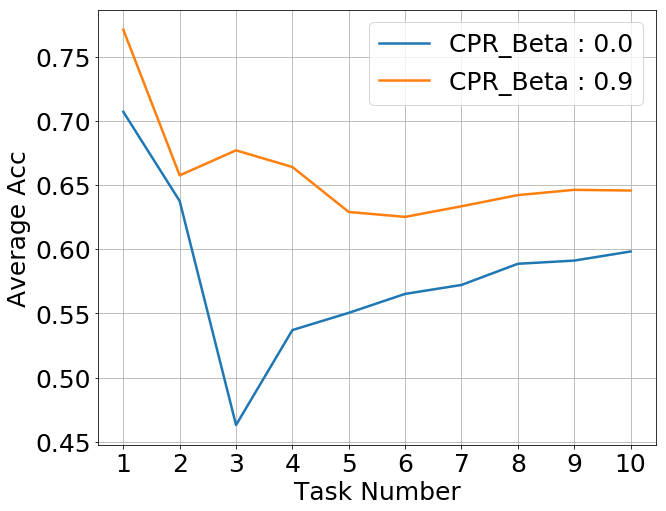

In [9]:
plt.figure(figsize=[10,8])
for beta in cpr_beta:
    plt.plot(A_arr[beta], linewidth=2.5, label='CPR_Beta : ' + str(beta))
plt.grid(True)
plt.xticks([i for i in range(num_tasks)],[str(i+1) for i in range(num_tasks)])
plt.xlabel('Task Number')
plt.ylabel('Average Acc')
plt.legend(loc='best')
plt.show()

In [10]:
print ('A' + str(num_tasks))
a_arr = []
for beta in cpr_beta:
    a_arr.append(round(A_arr[beta][-1], 4))
    print ('CPR_beta = ', str(beta), ' : ', round(A_arr[beta][-1], 4))
diff_A = round(a_arr[-1] - a_arr[0], 4)
diff_A_ratio = diff_A / a_arr[0]*100
print ('diff W-W/o : ', str(diff_A), ' (',str(round(diff_A_ratio,2)),'%)')
print ()

print ('F' + str(num_tasks))
f_arr = []
for beta in cpr_beta:
    f_arr.append(round(F_arr[beta], 4))
    print ('CPR_beta = ', str(beta), ' : ', round(F_arr[beta], 4))
diff_F = round(f_arr[-1] - f_arr[0], 4)
diff_F_ratio = diff_F / f_arr[0]*100
print ('diff W-W/o : ', str(diff_F), ' (',str(round(diff_F_ratio,2)),'%)')
print ()


print ('I' + str(num_tasks))
i_arr = []
for beta in cpr_beta:
    i_arr.append(round(I_arr[beta], 4))
    print ('CPR_beta = ', str(beta), ' : ', round(I_arr[beta], 4))
diff_I = round(i_arr[-1] - i_arr[0], 4)
diff_I_ratio = diff_I / i_arr[0]*100
print ('diff W-W/o : ', str(diff_I), ' (',str(round(diff_I_ratio,2)),'%)')

A10
CPR_beta =  0.0  :  0.5982
CPR_beta =  0.9  :  0.6457
diff W-W/o :  0.0475  ( 7.94 %)

F10
CPR_beta =  0.0  :  0.075
CPR_beta =  0.9  :  0.0637
diff W-W/o :  -0.0113  ( -15.07 %)

I10
CPR_beta =  0.0  :  0.1095
CPR_beta =  0.9  :  0.0721
diff W-W/o :  -0.0374  ( -34.16 %)
